### Imports


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
from jax.numpy import resize
import numpy as np
import cv2
import os
import zipfile
from google.colab.patches import cv2_imshow
from google.colab import files


### Functions

In [ ]:
from collections import Counter

# counting the number of shapes that we have on data_list
def count_shapes(data_list: list, cluster:bool=False, verbose:bool=True):
  # Extracting shapes of all elements in the data list
  shapes = [np.array(i).shape for i in data_list]
  count_shapes = Counter(shapes)
  shapes = list(count_shapes.keys())

  # Verbose checking: print all the shapes and their frequencies
  if verbose:
    for shape, shape_frequency in count_shapes.items():
        print(f"{shape}: {shape_frequency}")

  # creating a dict where its keys are the images shapes that we need to separe from the yellow_data and clustering them together
  if cluster:
    dict2store = {i:[] for i in shapes}

    for image in data_list:
      actual_shape = image.shape
      dict2store[actual_shape].append(jnp.array(image))

    return dict2store



def rescale(dataset:list, desired_shape:tuple, pad_mod:str):
  for i, raw_img in enumerate(dataset):
    desired_size = desired_shape
    height, width = raw_img.shape[:2]

    # Calculating the scale factor as the min(x_scale,y_scale)
    scale = min(desired_size[1] / width, desired_size[0] / height)

    # Calculating the new width and height, based on the scale factor got previously
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Rezing the image with the new (new_width, new_height) shape
    resized_image = cv2.resize(raw_img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    resized_image_shape = resized_image.shape[:2]

    diff = [abs(x-y) for x,y in zip(desired_shape, resized_image_shape)] # checking the differences between the targeted shape and the achieved shape

    # checking if the x-coordinate is even, if so, the padding will be the same on both sides, otherwise will be (x+1, x)
    x = diff[0]
    y = diff[1]

    if x % 2 == 0: pad_x = (int(x/2), int(x/2))
    else: pad_x = (int((x+1)/2), int((x-1)/2))

    if y % 2 == 0: pad_y = (int(y/2), int(y/2))
    else: pad_y = (int((y+1)/2), int((y-1)/2))

    padded_image = np.pad(resized_image, [pad_x, pad_y, (0,0)], mode=pad_mod)

    dataset[i] = padded_image

  return dataset

# Function that performs the rotation of the image by tranposing its axis
def rotate_img(image_dataset:list):
  for i, raw_img in enumerate(image_dataset):
    raw_img
    height, width = raw_img.shape[:2]

    if height < width:
      image_dataset[i] = np.transpose(raw_img, (1,0,2))

  return image_dataset



# save function to zip all samples
def save_data_sample(dataname:str, dataset:list, pad_mod:str="constant"):
  output_dir = f'/content/{dataname}_temp'
  os.makedirs(output_dir, exist_ok=True)

  image_paths = []  # paths to the images

  # saving all the images
  for i, img in enumerate(dataset):
      # defining the image and its path
      image_path = os.path.join(output_dir, f"{dataname}_squared_{pad_mod}_{i}.png")
      cv2.imwrite(image_path, img)              # saving the image using cv2.imwrite()
      image_paths.append(image_path)            # saving the image_path to the paths list

  # path to zip file
  zip_file = f'/content/{dataname}_images.zip'

  # creating the zip file
  with zipfile.ZipFile(zip_file, 'w') as zipf:
      for img_path in image_paths:
          zipf.write(img_path, os.path.basename(img_path))  # adding each image to .zip

  # checking if the zip_file was created
  os.path.exists(zip_file)

  # downloading the zip file
  files.download(zip_file)

# Yellow Samples: resizing pipeline




In [ ]:
yellow_data = [cv2.imread(f"yellow/yellow ({i}).jpeg") for i in range(1,506)]     # loading all the yellow diseases data and storing it on yellow_data variable

In [ ]:
separed_data = count_shapes(yellow_data, cluster=True)

In [ ]:
# From the above results, we know that the dataset contains images with different rotations, so the next step is to rotate all
shapes_tranpose = [(493, 1040, 3), (720, 1280, 3), (585, 1040, 3), (900, 1600, 3)]
desired_shape = (512, 512)
for i, raw_img in enumerate(yellow_data):
  if raw_img.shape in shapes_tranpose:
    yellow_data[i] = np.transpose(raw_img, (1,0,2))


In [ ]:
separed_data = count_shapes(yellow_data, cluster=True) # calling count_shapes() again to see if our results match the expectations

(1040, 493, 3): 450
(1280, 960, 3): 20
(1280, 720, 3): 1
(1040, 585, 3): 27
(1600, 900, 3): 7


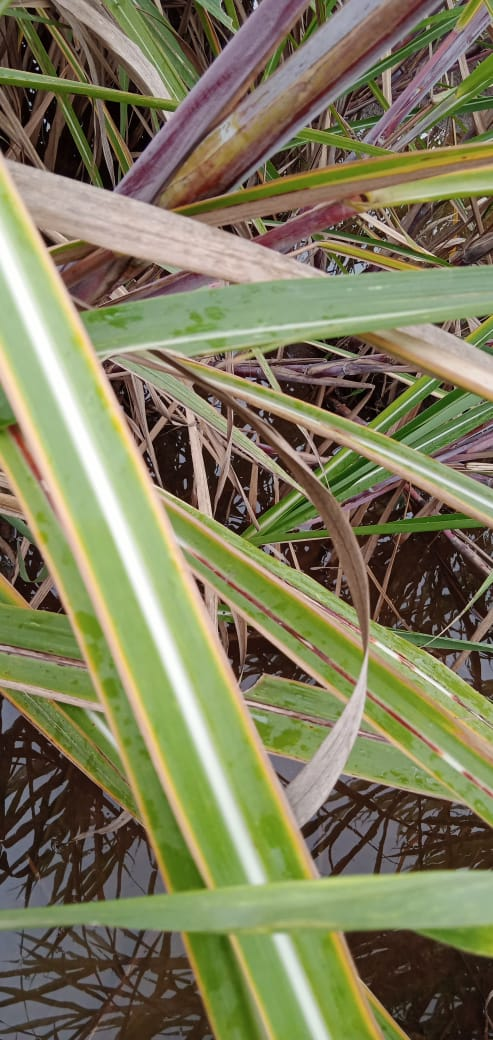

In [ ]:
cv2_imshow(np.array(yellow_data[300]))

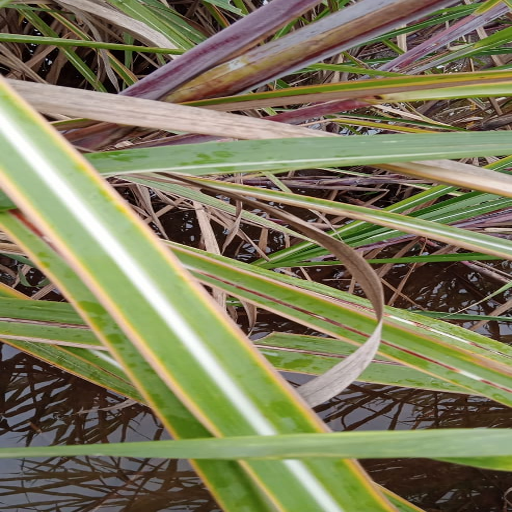

In [ ]:
cv2_imshow(np.array(yellow_data[300]))

In [ ]:
yellow_data = rescale(yellow_data, desired_shape)
yellow_data[150].shape

(512, 512, 3)

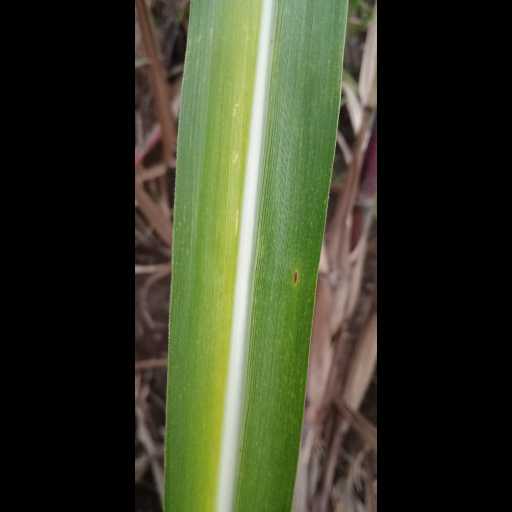

In [ ]:
cv2_imshow(np.array(yellow_data[150]))

# Rust Samples: resizing pipeline

In [ ]:
rust_data = [cv2.imread(f"rust/rust ({i}).jpeg") for i in range(1,515)]     # loading all the rust diseases data and storing it on rust_data variable
rust_count = count_shapes(rust_data, cluster=True)
#

(965, 780, 3): 2
(956, 780, 3): 1
(1040, 780, 3): 318
(967, 780, 3): 1
(949, 780, 3): 2
(958, 780, 3): 2
(780, 1040, 3): 71
(960, 720, 3): 1
(720, 960, 3): 1
(962, 780, 3): 1
(951, 780, 3): 1
(1280, 588, 3): 50
(588, 1280, 3): 1
(1600, 736, 3): 7
(1280, 576, 3): 7
(1599, 899, 3): 41
(1600, 1200, 3): 6
(1200, 1600, 3): 1


In [ ]:
# From the above results, we know that the dataset contains images with different rotations, so the next step is to rotate all using rotate_img() function
rust_rotated = rotate_img(rust_data)
rust_count = count_shapes(rust_rotated, cluster=True)

(965, 780, 3): 2
(956, 780, 3): 1
(1040, 780, 3): 389
(967, 780, 3): 1
(949, 780, 3): 2
(958, 780, 3): 2
(960, 720, 3): 2
(962, 780, 3): 1
(951, 780, 3): 1
(1280, 588, 3): 51
(1600, 736, 3): 7
(1280, 576, 3): 7
(1599, 899, 3): 41
(1600, 1200, 3): 7


In [ ]:
# Rescaling the images to 512x512 size
rust_rescaled = rescale(rust_rotated, (512,512), pad_mod="edge")
rust_count = count_shapes(rust_rescaled, cluster=True)

(512, 512, 3): 514


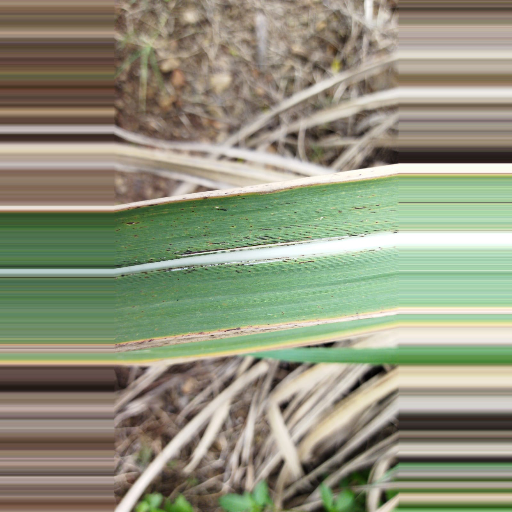

In [ ]:
cv2_imshow(np.array(rust_rescaled[150]))

In [ ]:
save_data_sample("rust", rust_rescaled, "edge")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Mosaic Samples: resizing pipeline


In [ ]:
# Loading mosaic dataset
mosaic_data = [cv2.imread(f"mosaic/mosaic ({i}).jpeg") for i in range(1,463)]
mosaic_count = count_shapes(mosaic_data, cluster=True)

# Rotating the images that need to be rotated
mosaic_rotated = rotate_img(mosaic_data)
mosaic_count = count_shapes(mosaic_rotated, cluster=True)

# Rescaling the images to 512x512 size
mosaic_rescaled = rescale(mosaic_rotated, (512,512), pad_mod="edge")
mosaic_count = count_shapes(mosaic_rescaled, cluster=True)
#

(1040, 585, 3): 23
(900, 1600, 3): 2
(1600, 900, 3): 12
(1040, 780, 3): 263
(960, 720, 3): 1
(493, 1040, 3): 43
(1040, 493, 3): 115
(780, 1040, 3): 3
(1040, 585, 3): 23
(1600, 900, 3): 14
(1040, 780, 3): 266
(960, 720, 3): 1
(1040, 493, 3): 158
(512, 512, 3): 462


(512, 512, 3)


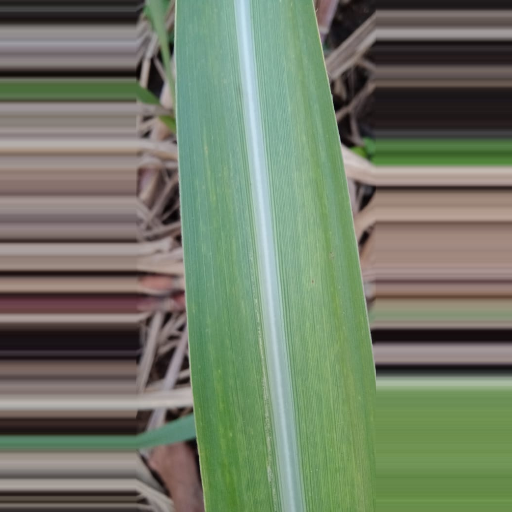

In [ ]:
# Plotting one sample
print(mosaic_rescaled[150].shape)
cv2_imshow(np.array(mosaic_rescaled[150]))

In [ ]:
save_data_sample("mosaic", mosaic_rescaled, "edge")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Red Rot Samples: resizing pipeline


In [ ]:
# Loading redrot dataset
redrot_data = [cv2.imread(f"redrot/redrot ({i}).jpeg") for i in range(1,519)]
redrot_count = count_shapes(redrot_data, cluster=True)

# Rotating the images that need to be rotated
redrot_rotated = rotate_img(redrot_data)
redrot_count = count_shapes(redrot_rotated, cluster=True)

# Rescaling the images to 512x512 size
redrot_rescaled = rescale(redrot_rotated, (512,512), pad_mod="constant")
redrot_count = count_shapes(redrot_rescaled, cluster=True)
#

(452, 736, 3): 1
(440, 913, 3): 1
(993, 493, 3): 7
(452, 842, 3): 1
(610, 493, 3): 1
(439, 931, 3): 1
(852, 493, 3): 1
(451, 892, 3): 1
(451, 900, 3): 1
(446, 1040, 3): 3
(455, 988, 3): 1
(447, 1040, 3): 2
(983, 493, 3): 12
(992, 493, 3): 8
(454, 1040, 3): 4
(453, 1040, 3): 3
(450, 1040, 3): 2
(445, 1040, 3): 1
(995, 493, 3): 2
(984, 493, 3): 8
(979, 493, 3): 5
(956, 493, 3): 1
(990, 493, 3): 8
(977, 493, 3): 5
(974, 493, 3): 3
(451, 1040, 3): 2
(988, 493, 3): 9
(981, 493, 3): 7
(986, 493, 3): 11
(452, 1040, 3): 4
(970, 493, 3): 2
(967, 493, 3): 1
(448, 1040, 3): 1
(976, 493, 3): 1
(360, 269, 3): 1
(301, 750, 3): 1
(699, 245, 3): 1
(327, 1000, 3): 1
(295, 750, 3): 1
(292, 750, 3): 1
(819, 420, 3): 1
(553, 240, 3): 1
(374, 300, 3): 1
(891, 750, 3): 1
(525, 323, 3): 1
(678, 1000, 3): 2
(677, 1000, 3): 1
(928, 750, 3): 7
(913, 750, 3): 2
(930, 750, 3): 1
(661, 1000, 3): 1
(918, 750, 3): 5
(914, 750, 3): 8
(926, 750, 3): 4
(916, 750, 3): 1
(670, 1000, 3): 1
(908, 750, 3): 5
(920, 750, 3): 

(512, 512, 3)


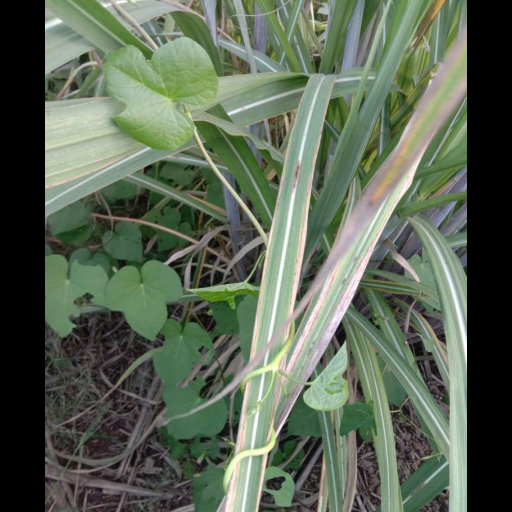

In [ ]:
# Plotting one sample
print(redrot_rescaled[150].shape)
cv2_imshow(np.array(redrot_rescaled[150]))

In [ ]:
save_data_sample("redrot", redrot_rescaled, "constant")

# Healthy Samples: resizing pipeline

In [ ]:
# Loading healthy dataset
healthy_data = [cv2.imread(f"healthy/healthy ({i}).jpeg") for i in range(1,523)]
healthy_count = count_shapes(healthy_data, cluster=True)
print()

# Rotating the images that need to be rotated
healthy_rotated = rotate_img(healthy_data)
healthy_count = count_shapes(healthy_rotated, cluster=True)
print()

# Rescaling the images to 512x512 size
healthy_rescaled = rescale(healthy_rotated, (512,512), pad_mod="edge")
healthy_count = count_shapes(healthy_rescaled, cluster=True)
#

(493, 1040, 3): 40
(1040, 493, 3): 300
(1600, 758, 3): 13
(758, 1600, 3): 9
(1280, 622, 3): 21
(622, 1280, 3): 1
(585, 1040, 3): 5
(1040, 585, 3): 92
(899, 1599, 3): 1
(1000, 750, 3): 27
(816, 612, 3): 10
(612, 816, 3): 2
(750, 1000, 3): 1

(1040, 493, 3): 340
(1600, 758, 3): 22
(1280, 622, 3): 22
(1040, 585, 3): 97
(1599, 899, 3): 1
(1000, 750, 3): 28
(816, 612, 3): 12

(512, 512, 3): 522


(512, 512, 3)


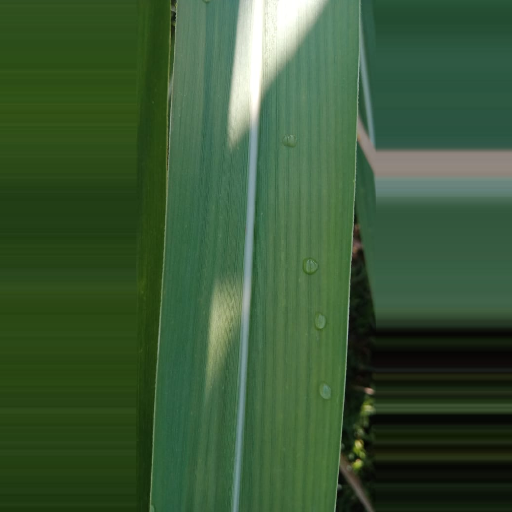

In [ ]:
# Plotting one sample
print(healthy_rescaled[150].shape)
cv2_imshow(np.array(healthy_rescaled[150]))

In [ ]:
save_data_sample("healthy", healthy_rescaled, "edge")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>